# Runtime Comparison and Linear Regression Methods

In this analysis I compare the runtimes of different methods to fit an ordinary least squares regression model. I fit a multivariate normal random sample using Scikit-Learn’s Linear Model module, statsmodels’ sm module, and with simple matrix multiplication. The result was three clear runtime distributions with simple matrix multiplication having the fastest mean runtime, followed by the Scikit-Learn then statsmodels methods. The results suggest that the most computationally efficient method for fitting ordinary least squares regression models with 0 intercept is using Numpy’s vectorized matrix multiplication. However, in practice, the average runtimes differ by hundredths of seconds so the relevant efficiency gains may be negligible.

In [2]:
import matplotlib.pyplot as plt
import timeit
import numpy as np

## Setup
For each trial, I generated a $N_{200}(0,1)$ random sample with 10,000 rows. The first 199 variables were fit to the $200^{th}$ variable and since the data was already centered, I fit each model without an intercept. For the matrix multiplication method, I made use of the fact the an ordinary least squares regression model is fitted as $\hat{\beta} = (X'X)^{-1}X'Y$.

In [3]:
setup_sklearn = '''
import numpy as np
import statsmodels.api as sm
from sklearn import linear_model
import random
n = 10000
p = 200
'''

model_sklearn = '''  
sample = np.random.normal(0,1,(n,p))
linear_model.LinearRegression(fit_intercept=False).fit(sample[:,0:p-1], sample[:,p-1:p])
'''
  
def sklearn_method():
    execution_time = timeit.timeit(setup = setup_sklearn, stmt = model_sklearn, number = 1)
    return execution_time

In [4]:
setup_statsmodels = '''
import numpy as np
import statsmodels.api as sm
from sklearn import linear_model
import random
n = 10000
p = 200
'''

model_statsmodels = '''  
sample = np.random.normal(0,1,(n,p))
sm.OLS(sample[:,p-1:p], sample[:,0:p-1])
'''
  
def statsmodels_method():
    execution_time = timeit.timeit(setup = setup_statsmodels, stmt = model_statsmodels, number = 1)
    return execution_time

In [5]:
setup_matmul = '''
import numpy as np
import statsmodels.api as sm
from sklearn import linear_model
import random
n = 10000
p = 200
'''

model_matmul = '''  
sample = np.random.normal(0,1,(n,p))
np.matmul(np.matmul(np.linalg.inv(np.matmul(np.transpose(sample[:,0:p-1]),
                                            sample[:,0:p-1])),np.transpose(sample[:,0:p-1])),sample[:,p-1:p])
'''
  
# timeit statement  
def matmul_method():
    execution_time = timeit.timeit(setup = setup_matmul, stmt = model_matmul, number = 1)
    return execution_time

## Results
I ran each method 1000 times on my Dell XPS running Windows 10 with 16gb of ram. The $i^{th}$ trial of each method was conducted together to control for the effects of the OS since it may run slower at times. I also imported the same Python modules for each method to reduce bias from importing packages (e.g. The statsmodels trials imported Sklearn even though it was not used). 

In [6]:
#sample size
n_sample = 1000

sklearn_method_results = np.empty((n_sample),dtype=np.longfloat)
statsmodels_method_results = np.empty((n_sample),dtype=np.longfloat)
matmul_method_results = np.empty((n_sample),dtype=np.longfloat)
for i in range(0,n_sample): 
    sklearn_method_results[i] = sklearn_method()
    statsmodels_method_results[i] = statsmodels_method()
    matmul_method_results[i] = matmul_method()

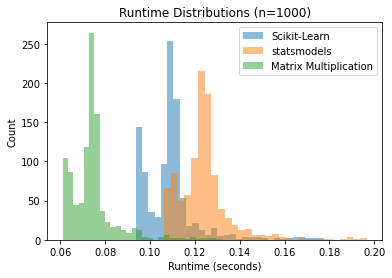

Sci-Kit Learn mean runtime:  0.1091
statsmodels mean runtime:  0.1239
Matrix Multiplication mean runtime:  0.0743


In [11]:
n_bins = 30
plt.hist(sklearn_method_results, bins = n_bins , alpha=0.5, label='Scikit-Learn')
plt.hist(statsmodels_method_results, bins = n_bins , alpha=0.5, label='statsmodels')
plt.hist(matmul_method_results, bins = n_bins, alpha=0.5, label='Matrix Multiplication')
plt.legend(loc='upper right')
plt.title('Runtime Distributions (n=1000)')
plt.xlabel('Runtime (seconds)')
plt.ylabel('Count')
plt.savefig('./figures/results.png')
plt.show()

print('Sci-Kit Learn mean runtime: ',round(np.mean(sklearn_method_results),4))
print('statsmodels mean runtime: ',round(np.mean(statsmodels_method_results),4))
print('Matrix Multiplication mean runtime: ',round(np.mean(matmul_method_results),4))

After 1000 trials of each method, three distinct distributions appeared. The matrix multiplication method was the clear winner with an average runtime of 0.07 seconds. The Scikit-Learn method produced the next lowest mean runtime at 0.11 seconds and the slowest was the statsmodel method with a mean runtime of 0.12 seconds.

Although the matrix multiplication method is the clear winner, its implementation is a bit messier than the Scikit-Learn implementation. Furthermore, the small increase in computation time probably has little to no practical relevancy. Scikit-Learn also easily accounts for modifications like a non-zero intercept. 

## Central Limit Theorem Digression

In the above histogram, we see the runtimes from the Scikit-Learn method is clearly not normally distributed. However, I sampled these runtimes 500 times using a sample size of 150. As a demonstration of the central limit theorem, we can see that the means of the $n=150$ samples are approximately  normally distributed since $n$ is large.

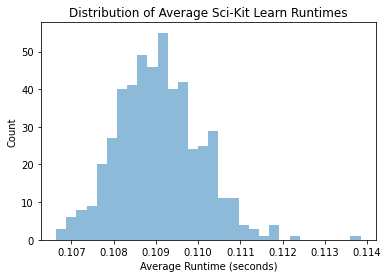

In [10]:
clt_results = np.empty((500),dtype=np.longfloat)
for i in range(0,500):
    clt_sample = np.random.choice(sklearn_method_results, size=150)
    clt_results[i] = np.mean(clt_sample)

plt.hist(clt_results, bins = 30 , alpha=0.5)
plt.title('Distribution of Average Sci-Kit Learn Runtimes')
plt.xlabel('Average Runtime (seconds)')
plt.ylabel('Count')
plt.savefig('./figures/clt.png')
plt.show()